# Predicting User Activity using localization data

This arithmetica practice is from the paper An Agent-based Approach to Care in Independent Living posted at UCI.
http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=D4F68AC886F5F0470207D1ACB782BF7A?doi=10.1.1.301.3380&rep=rep1&type=pdf


The paper introduces a fall detector based on a neural network and a multi-agent architecture for requesting emergency services. It presented a multi-agent system for the care of elderly people living at home on their own, with the aim to prolong their independence. The system is composed of seven groups of agents providing a reliable, robust and flexible monitoring by sensing the user in the environment, reconstructing the position and posture to create the physical awareness of the user in the environment, reacting to critical situations, calling for help in the case of an emergency, and issuing warnings if unusual behavior is detected. The system has been tested during several on-line demonstration. People used for recording of the data were wearing four tags (ankle left, ankle right, belt and chest). Each instance is a localization data for one of the tags. The tag can be identified by one of the attributes. The goal for this practice is to correctly predict the activity the user is performing.


In [15]:
import pandas as pd
# Read Data from URL
# NOTE: download file or get path from arithmetica 
train_url = "http://arithmetica.io/media/data/...."
test_url = "http://arithmetica.io/media/data/...."
soultion_url = "http://arithmetica.io/media/data/...."
train=pd.read_csv(train_url)
test = pd.read_csv(test_url)
solution = pd.read_csv(soultion_url)

In [16]:
print (train.shape)
print (test.shape)
print (solution.shape)

(131887, 9)
(32972, 8)
(32972, 2)


In [17]:
train.dtypes

ID             int64
sequence      object
tag           object
timestamp    float64
date          object
xcord        float64
ycord        float64
zcord        float64
activity      object
dtype: object

In [18]:
train.head()

,ID,sequence,tag,timestamp,date,xcord,ycord,zcord,activity
0,119546,D05,010-000-024-033,6.337902e+17,27.05.2009 12:29:36:757,3.462888,2.263080,0.370799,standing up from sitting on the ground
1,109888,D04,020-000-032-221,6.337902e+17,27.05.2009 12:21:44:050,1.878930,1.605515,0.694254,sitting
2,131809,E02,020-000-033-111,6.337901e+17,27.05.2009 11:16:01:287,4.808895,1.326455,0.311465,lying
3,93164,D01,020-000-033-111,6.337902e+17,27.05.2009 12:01:56:630,4.083691,1.330411,0.355516,standing up from lying
4,77810,C04,020-000-033-111,6.337903e+17,27.05.2009 15:45:15:980,3.733828,1.144829,0.578826,standing up from lying


In [19]:
test.head()

,ID,sequence,tag,timestamp,date,xcord,ycord,zcord
0,1,A01,020-000-033-111,6.337902e+17,27.05.2009 14:03:25:183,4.291954,1.781140,1.344495
1,5,A01,020-000-033-111,6.337902e+17,27.05.2009 14:03:25:290,4.364077,1.767691,1.299996
2,13,A01,010-000-024-033,6.337902e+17,27.05.2009 14:03:25:560,3.748375,2.073422,0.254482
3,15,A01,010-000-024-033,6.337902e+17,27.05.2009 14:03:25:670,3.820894,2.049378,0.055377
4,16,A01,010-000-030-096,6.337902e+17,27.05.2009 14:03:25:697,4.355477,1.990151,0.501698


In [20]:
# generate 'activitydf' DF
actdf = pd.DataFrame(train['activity'].value_counts().reset_index())
actdf.columns = ['activity', 'count']
actdf

,activity,count
0,lying,43624
1,walking,26146
2,sitting,21780
3,standing up from lying,14642
4,sitting on the ground,9468
5,lying down,4942
6,on all fours,4138
7,falling,2372
8,standing up from sitting on the ground,2307
9,sitting down,1372


## Date Analysis
Lets convert string to date, hour, minute, weekday and month of the year

In [21]:
import datetime
from datetime import datetime
import calendar

train["onlydate"] = train.date.apply(lambda x : x.split()[0])
train["hour"] = train.date.apply(lambda x : x.split()[1].split(":")[0])
train["min"] = train.date.apply(lambda x : x.split()[1].split(":")[1])

train["weekday"] = train.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%d.%m.%Y %H:%M:%S:%f").weekday()])
train["month"] = train.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%d.%m.%Y %H:%M:%S:%f").month])
# drop non-necessary columns
train  = train.drop(["date"],axis=1)

In [22]:
train.head()

,ID,sequence,tag,timestamp,xcord,ycord,zcord,activity,onlydate,hour,min,weekday,month
0,119546,D05,010-000-024-033,6.337902e+17,3.462888,2.263080,0.370799,standing up from sitting on the ground,27.05.2009,12,29,Wednesday,May
1,109888,D04,020-000-032-221,6.337902e+17,1.878930,1.605515,0.694254,sitting,27.05.2009,12,21,Wednesday,May
2,131809,E02,020-000-033-111,6.337901e+17,4.808895,1.326455,0.311465,lying,27.05.2009,11,16,Wednesday,May
3,93164,D01,020-000-033-111,6.337902e+17,4.083691,1.330411,0.355516,standing up from lying,27.05.2009,12,01,Wednesday,May
4,77810,C04,020-000-033-111,6.337903e+17,3.733828,1.144829,0.578826,standing up from lying,27.05.2009,15,45,Wednesday,May


## Output Activity

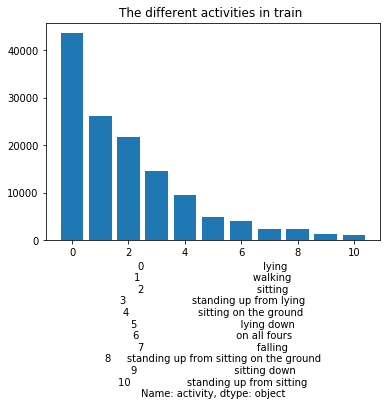

In [10]:
import matplotlib.pyplot as plt
numbers_train = range(0,len(actdf))
plt.bar(numbers_train,actdf['count'])
plt.title("The different activities in train ")
plt.xlabel(actdf['activity'])
plt.show()
#print("The different activities in train and test")


## Check sequence 

In [11]:
# generate 'seqdf' DF
testseqdf = pd.DataFrame(test['sequence'].value_counts().reset_index())
testseqdf.columns = ['seq', 'testcount']
numberstest = range(0,len(testseqdf))

seqdf = pd.DataFrame(train['sequence'].value_counts().reset_index())
seqdf.columns = ['seq', 'traincount']
numbers = range(0,len(seqdf))

testseqdf = testseqdf.sort_values(by ='seq')
seqdf = seqdf.sort_values(by ='seq')
sequence = pd.merge(testseqdf, seqdf, on="seq",how='inner')


In [12]:
sequence.head()

,seq,testcount,traincount
0,A01,1179,4650
1,A02,1123,4568
2,A03,1079,4247
3,A04,1031,4371
4,A05,1032,4192


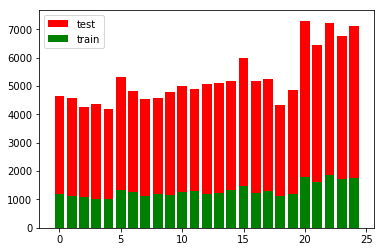

In [13]:
import matplotlib.pyplot as plt
mylist1 = range(0,len(sequence))
mylist2 = sequence['testcount']
mylist3 = sequence['traincount']
#plt.bar ( position, list, ....)
plt.bar(mylist1,mylist3,label='test',color="red")
plt.bar(mylist1,mylist2,label='train',color="green")
plt.legend()
plt.show()


In [ ]:
train.dtypes

## X-Y-Z Co-ordinates

In [14]:
train[['xcord','ycord','zcord']] = train[['xcord','ycord','zcord']].apply(pd.to_numeric)

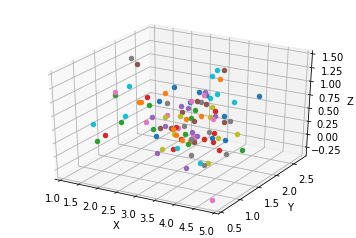

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

for row in range(0, 100):
    ax.scatter(train.iloc[row]["xcord"], train.iloc[row]["ycord"], train.iloc[row]["zcord"])
    
ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')

plt.show()

In [ ]:
train.head()

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

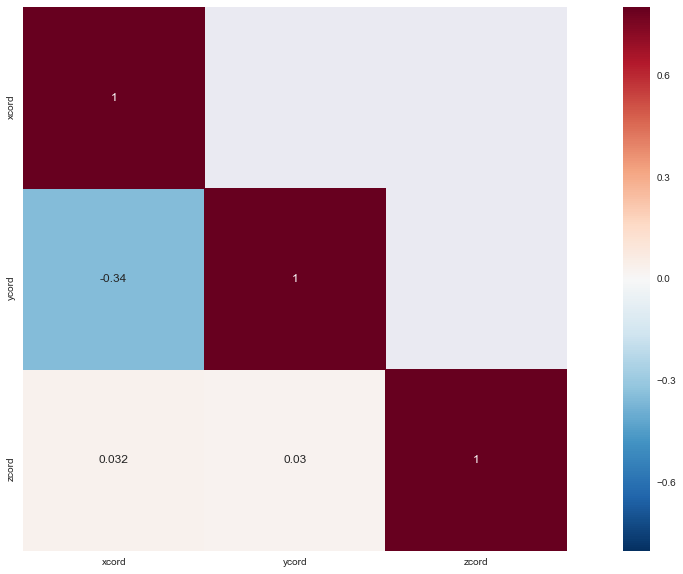

In [18]:
#import missingno as msno
import seaborn as sn
corrMatt = train[["sequence","tag","xcord","ycord","zcord","activity"]].corr()

#corrMatt = train[["sequence","tag","xcord","ycord","zcord","onlydate","hour","min","activity"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

Using Plotly to visualizae

In [19]:
import plotly as py
py.tools.set_credentials_file(username='<>', api_key='<>')

#import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

#x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
train = train[0:200]
trace1 = go.Scatter3d(x=train["xcord"],y=train["ycord"],z=train["zcord"],mode='markers')

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='simple-3d-scatter')